# Introduction

This is a cleaner version of the framework prototype. 

The steps will be encapsulated in a function, and called one after another after.

We will use the easy toy dataset generated in v1.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from pycpd import RigidRegistration
from sklearn.neighbors import KNeighborsClassifier

from functools import partial
from cycpd import rigid_registration, affine_registration, deformable_registration
from PIL import Image


In [2]:
df = pd.read_csv("../data/toy_data_2batches_2pops.csv", index_col=0)
df.head()

,CD69,CD99,Population,Batch
0,2.729573,14.642127,pop_1,ref
1,2.108741,15.071990,pop_1,ref
2,3.222132,15.074051,pop_1,ref
3,1.758534,14.243902,pop_1,ref
4,3.125349,15.468494,pop_1,ref


Separate the dataframe into reference (this will be soulcap reference data in the future) and new data from user.

In [3]:
df_ref = df[(df['Batch'] == 'ref')]

df_new = df[(df['Batch'] == 'batch_1')]
# rename the batch to user data
df_new.loc[:, 'Batch'] = 'user_data'
df_new.head()

,CD69,CD99,Population,Batch
10000,8.690130,29.869319,pop_1,user_data
10001,9.409027,30.775588,pop_1,user_data
10002,10.149282,30.735540,pop_1,user_data
10003,9.771453,31.757215,pop_1,user_data
10004,8.461216,30.831674,pop_1,user_data


# PPM

First, pretend we already have PPM generated for our reference and new data.

In [4]:
def generate_ppm(x_vals, y_vals, grid_size=32):
    # grid_size = [10, 32]
    # x then y (x=10, y=32)
    # if one value, then square grid.
    # cartesian plotting and numpy 2d histogram has 2 different orientation.
    # 1st argument in histogram2d is x-axis (CD69), but becomes rows in output.
    # 2nd argument in histogram2d is y-axis (CD99), but becomes columns in output.
    ppm, xedges, yedges = np.histogram2d(
        x=x_vals, 
        y=y_vals, 
        bins=grid_size
    )

    # note the ppm output here, x_vals (CD69) will be rows
    # y_vals (CD99) is columns.
    # it's just the way numpy intrepret x and y differently from us.

    # Normalize to get probabilities
    total_cells = len(x_vals)
    ppm = ppm / total_cells

    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])

    # get bin ids and probabilities
    # get position and index of bins
    bin_coords = []
    bin_id = 0
    for x_idx in range(len(xcenters)):
        for y_idx in range(len(ycenters)):
            bin_coords.append([
                f"bin_{x_idx}_{y_idx}",
                xedges[x_idx],
                xedges[x_idx+1],
                xcenters[x_idx],
                yedges[y_idx],
                yedges[y_idx+1],
                ycenters[y_idx],
                ppm[x_idx, y_idx]
            ])
            bin_id += 1
    bin_coords = pd.DataFrame(bin_coords, columns=["bin_id", "x_min", "x_max", "x_center", "y_min", "y_max", "y_center", "prob"])

    # Find bin index for each point
    # Default behavior is (right==False) indicating that the interval does not include the right edge.
    # Subtract 1 to get 0-based bin index
    x_bin = np.digitize(x_vals, xedges) - 1  
    # digitize operate off the bin edges.
    # any value that is >= last bin edge will be given the len(xedges) id.
    # which does not exist as we only have len(xedges)-1 bins.
    # hence we need to clip the bins so it maxed out at number of bins - 1
    x_bin = np.clip(x_bin, 0, grid_size - 1)

    y_bin = np.digitize(y_vals, yedges) - 1
    y_bin = np.clip(y_bin, 0, grid_size - 1)

    bin_ids = [f"bin_{x_idx}_{y_idx}" for x_idx, y_idx in zip(x_bin, y_bin)]

    return bin_coords, bin_ids

Generate PPM for the reference and new data.

In [8]:
ppm_ref_bin_coords, bin_ids = generate_ppm(
    x_vals=df_ref['CD69'].to_numpy(),
    y_vals=df_ref['CD99'].to_numpy(),
    grid_size=32
)
df_ref_with_bins = df_ref.copy(deep=True)
df_ref_with_bins.loc[:, 'bin_id'] = bin_ids

ppm_dat_bin_coords, bin_ids = generate_ppm(
    x_vals=df_new['CD69'].to_numpy(),
    y_vals=df_new['CD99'].to_numpy(),
    grid_size=32
)
df_new_with_bins = df_new.copy(deep=True)
df_new_with_bins.loc[:, 'bin_id'] = bin_ids


Sanity check the bins and points assignments

In [ ]:
for x, bin_id in zip(df_ref_with_bins['CD69'], df_ref_with_bins['bin_id']):
     bin_coord = ppm_ref_bin_coords[ppm_ref_bin_coords['bin_id'] == bin_id]
     if not (x >= bin_coord['x_min'].values[0] and x <= bin_coord['x_max'].values[0]):
          print(f"{x}, {bin_id}, oops")

for y, bin_id in zip(df_ref_with_bins['CD99'], df_ref_with_bins['bin_id']):
     bin_coord = ppm_ref_bin_coords[ppm_ref_bin_coords['bin_id'] == bin_id]
     if not (y >= bin_coord['y_min'].values[0] and y <= bin_coord['y_max'].values[0]):
          print(f"{y}, {bin_id}, oops")

Text(0.5, 1.0, 'PPM New data')

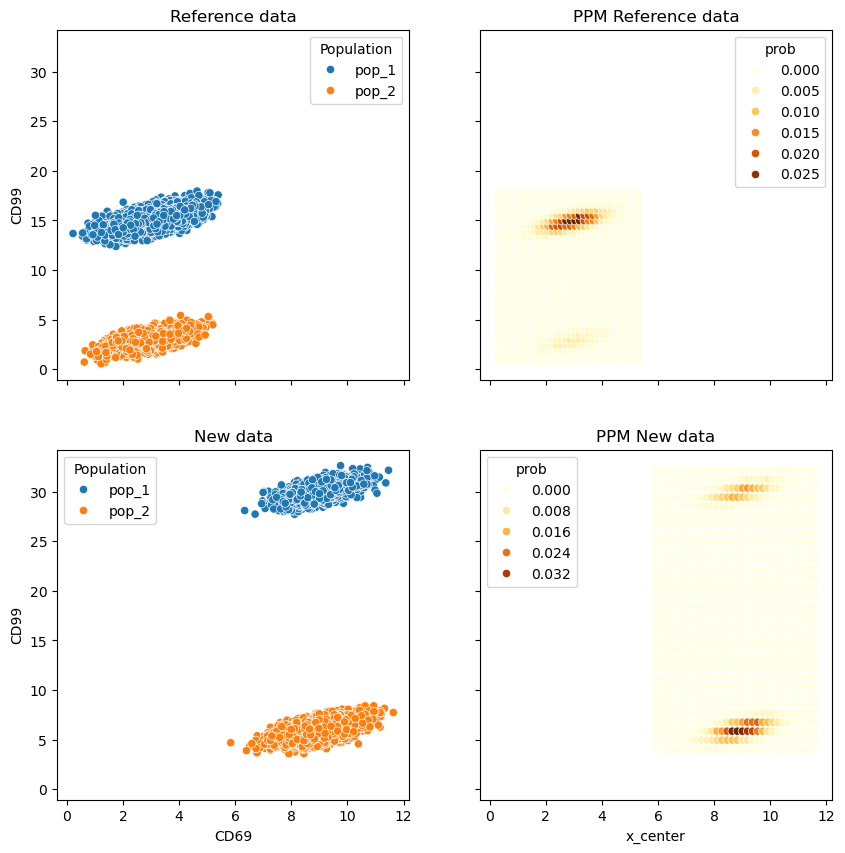

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df_ref_with_bins,
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[0][0]
).set_title("Reference data")

# plot the reference data first
sns.scatterplot(
    data=ppm_ref_bin_coords,
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[0][1],
    palette='YlOrBr'
).set_title("PPM Reference data")

sns.scatterplot(
    data=df_new_with_bins,
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[1][0]
).set_title("New data")

sns.scatterplot(
    data=ppm_dat_bin_coords,
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[1][1],
    palette="YlOrBr"
).set_title("PPM New data")

# Generate weighted point set

In [33]:
def generate_weighted_point_set(
    ppm_bins_df,
    probability_threshold=0.0005,
    adaptive_sampling=True,
    max_points_per_bin=10
):
    """
    Generate a weighted point set from a Probability Point Map (PPM).

    Args:
        ppm_bins_df (pd.DataFrame): DataFrame with columns ['bin_id', 'x_center', 'y_center', 'prob'].
        probability_threshold (float, optional): Minimum probability for a bin to be included. Defaults to 0.0005.
        adaptive_sampling (bool, optional): If True, sample more points in higher-probability bins. If False, one point per bin. Defaults to True.
        max_points_per_bin (int, optional): Maximum points sampled per bin. Defaults to 10.

    Returns:
        points (np.ndarray): Array of (x, y) coordinates.
        weights (np.ndarray): Array of normalized weights for each point.
    """

    # Find the maximum probability for scaling
    max_probability = ppm_bins_df['prob'].max()

    # Keep only bins above the probability threshold
    bins_above_thresh = ppm_bins_df[ppm_bins_df['prob'] > probability_threshold]

    bin_probs = bins_above_thresh['prob']
    bin_x_centers = bins_above_thresh['x_center'].to_numpy()
    bin_y_centers = bins_above_thresh['y_center'].to_numpy()

    if adaptive_sampling:
        # Scale number of points per bin by probability, capped at max_points_per_bin.
        # We scale the probability again so the bin with max_probability end up with max_points_per_bin points.
        # E.g., if we have probabilities of 0.2, 0.5, 0.6, 
        # dividing by max probability will yield 0.3, 0.83, 1.
        # Multiply this by max_points_per_bin will yield 3, 8, 10 points.
        scaled_probs = bin_probs / max_probability
        points_per_bin = np.maximum(
            1,
            np.ceil(scaled_probs * max_points_per_bin).astype(int)
        )

        # Generate random jitter for all points
        total_points = points_per_bin.sum()
        jitter = np.random.uniform(0.1, 0.9, (total_points, 2))

        # Repeat bin centers according to how many points each bin gets
        sampled_x = np.repeat(bin_x_centers, points_per_bin)
        sampled_y = np.repeat(bin_y_centers, points_per_bin)

        # Add jitter to bin centers
        points = np.column_stack([
            sampled_x + jitter[:, 0],
            sampled_y + jitter[:, 1]
        ])
        point_weights = np.repeat(bin_probs, points_per_bin)
    else:
        # One point per bin
        points = np.column_stack([bin_x_centers, bin_y_centers])
        point_weights = bin_probs

    # Normalize weights to sum to 1
    point_weights /= point_weights.sum()

    return points, point_weights


In [34]:
# use the default parameters
ref_set_points, _ = generate_weighted_point_set(ppm_bins_df=ppm_ref_bin_coords)
new_dat_set_points, _ = generate_weighted_point_set(ppm_bins_df=ppm_dat_bin_coords)

Sanity check of the points

In [37]:
set_points = pd.DataFrame(
    np.concat([ref_set_points, new_dat_set_points]), 
    columns=['x','y']
)
set_points['batch'] = np.concat([
    np.repeat('ref', len(ref_set_points)),
    np.repeat('new_data', len(new_dat_set_points))
])


Text(0.5, 1.0, 'Generated weighted point')

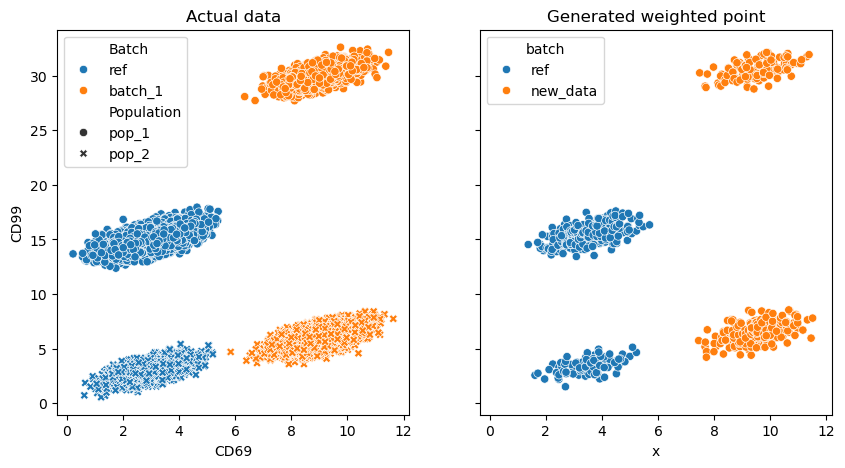

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df,
    x='CD69',
    y='CD99',
    hue='Batch',
    style='Population',
    ax=ax[0]
).set_title("Actual data")

sns.scatterplot(
    data=set_points,
    x='x',
    y='y',
    hue='batch',
    ax=ax[1]
).set_title("Generated weighted point")


# CPD

Test few CPDs while add in some diagnostics.

From cycpd animation, it may well be best that:

1. The weighted set points for new data is more concentrated in the center (area with very high probability) - lots of it, and as CPD iteration undergoes, it expands. Have some points at the border, but not as many. 
2. More weighted points for reference than new data?

The code generate the animation of the data post each iteration.

In [60]:
def visualize(iteration, error, X, Y, ax, fig, plt_prefix, save_fig=False):
    plt.cla()
    ax.cla()

    ax.scatter(X[:, 0], X[:, 1], color="blue", label="Target", alpha=0.5, s=3)
    ax.scatter(Y[:, 0], Y[:, 1], color="orange", label="Source", alpha=0.8, s=3)
    ax.legend(loc="upper left", fontsize="x-large")
    ax.text(
        0.87,
        0.92,
        "Iteration: {:d}\nError: {:06.4f}".format(iteration, error),
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize="x-large",
    )
    plt.draw()
    if save_fig is True:
        fig.savefig("../plots/{}/{}_{:04}.tiff".format(plt_prefix, plt_prefix, iteration))  # Used for making gif.

    plt.pause(0.001)

## Rigid registration

Iteration:1
ML:  -193.688; 	ML change (error):   193.688; 	Sigma^2:    11.923; 	Sigma^2 change:    87.784
[                                                                        ]


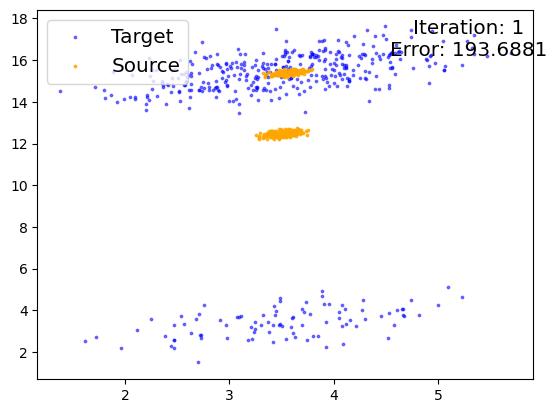

Iteration:2
ML: -1031.667; 	ML change (error):   837.978; 	Sigma^2:    11.012; 	Sigma^2 change:     0.911
[=                                                                       ]


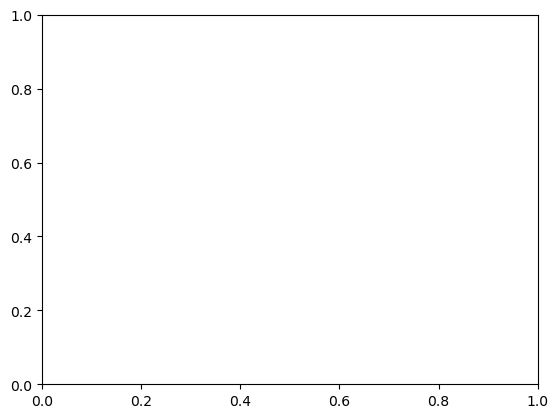

Iteration:3
ML: -1045.333; 	ML change (error):    13.666; 	Sigma^2:    10.362; 	Sigma^2 change:     0.650
[==                                                                      ]


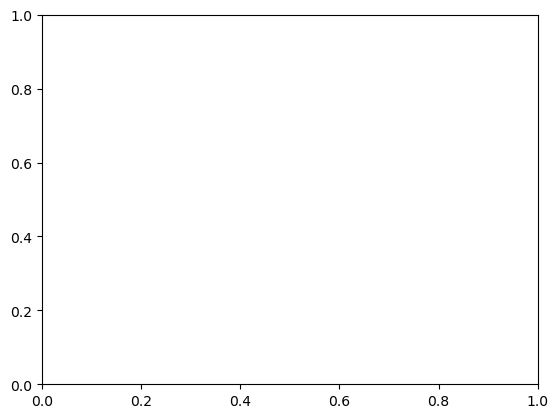

Iteration:4
ML: -1051.098; 	ML change (error):     5.765; 	Sigma^2:     9.833; 	Sigma^2 change:     0.529
[==                                                                      ]


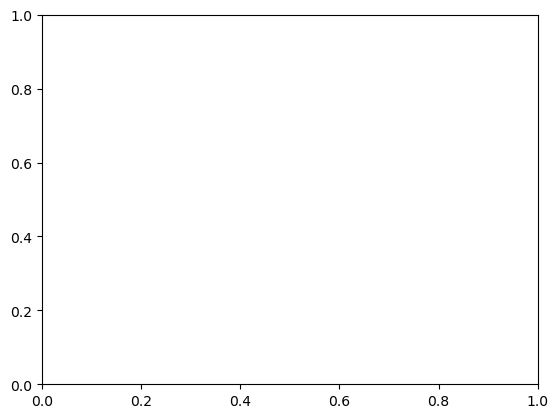

Iteration:5
ML: -1055.264; 	ML change (error):     4.165; 	Sigma^2:     9.331; 	Sigma^2 change:     0.502
[===                                                                     ]


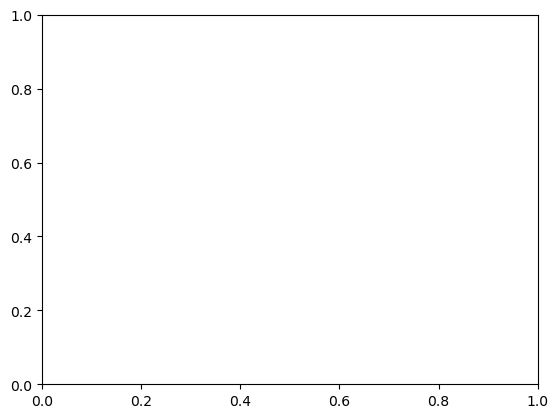

Iteration:6
ML: -1059.811; 	ML change (error):     4.547; 	Sigma^2:     8.732; 	Sigma^2 change:     0.599
[====                                                                    ]


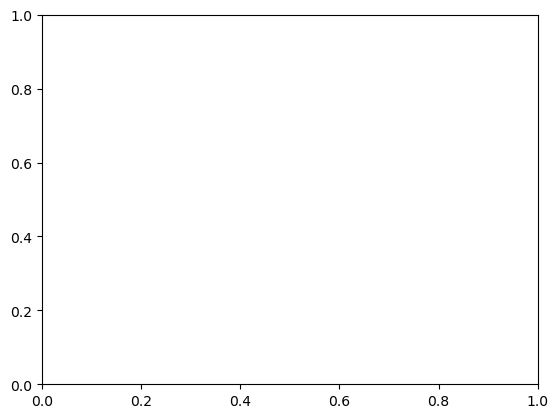

Iteration:7
ML: -1067.539; 	ML change (error):     7.728; 	Sigma^2:     7.819; 	Sigma^2 change:     0.913
[=====                                                                   ]


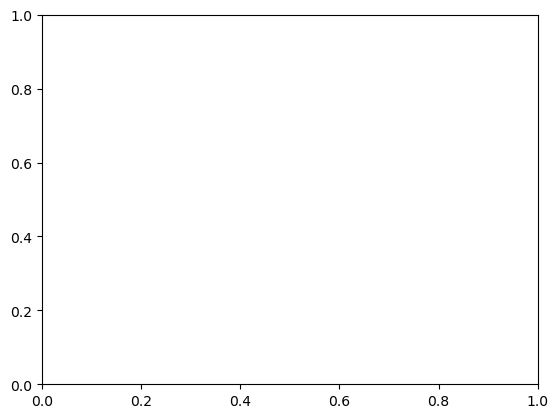

Iteration:8
ML: -1089.214; 	ML change (error):    21.675; 	Sigma^2:     5.963; 	Sigma^2 change:     1.856
[=====                                                                   ]


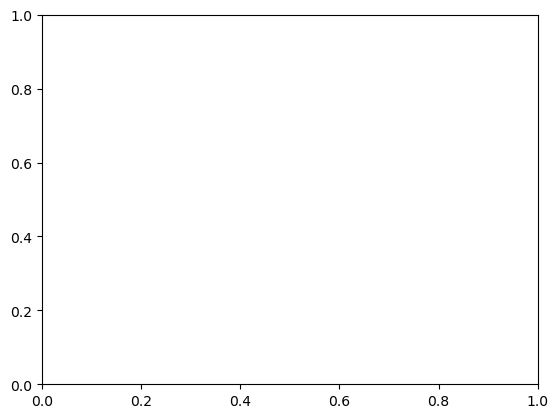

Iteration:9
ML: -1195.548; 	ML change (error):   106.334; 	Sigma^2:     1.834; 	Sigma^2 change:     4.129
[======                                                                  ]


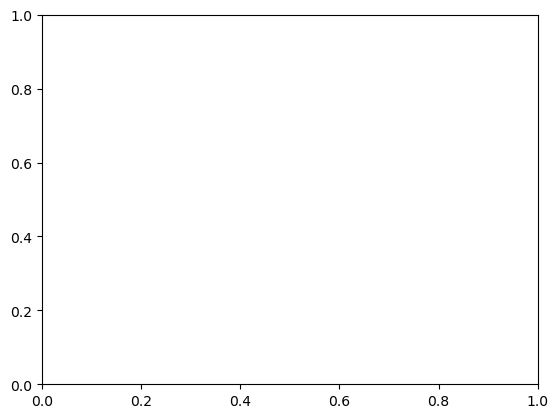

Iteration:10
ML: -1720.336; 	ML change (error):   524.788; 	Sigma^2:     0.658; 	Sigma^2 change:     1.175
[=======                                                                 ]


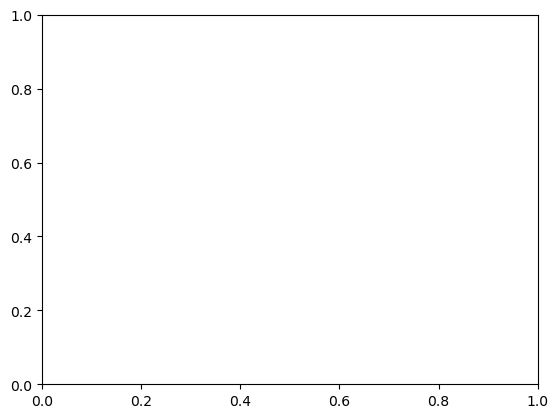

Iteration:11
ML: -1958.821; 	ML change (error):   238.485; 	Sigma^2:     0.488; 	Sigma^2 change:     0.170
[=======                                                                 ]


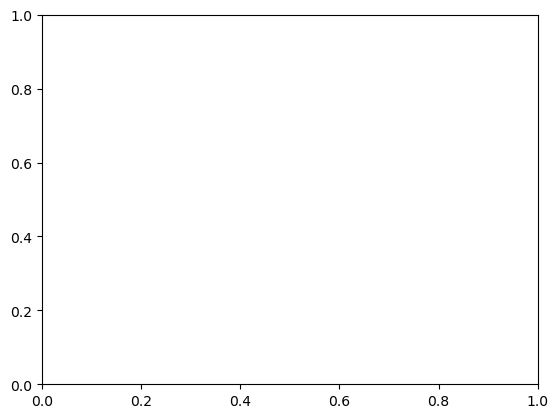

Iteration:12
ML: -1985.956; 	ML change (error):    27.135; 	Sigma^2:     0.428; 	Sigma^2 change:     0.060
[========                                                                ]


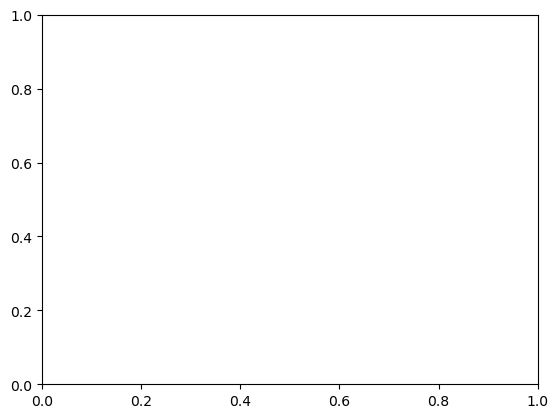

Iteration:13
ML: -1991.783; 	ML change (error):     5.827; 	Sigma^2:     0.401; 	Sigma^2 change:     0.027
[=========                                                               ]


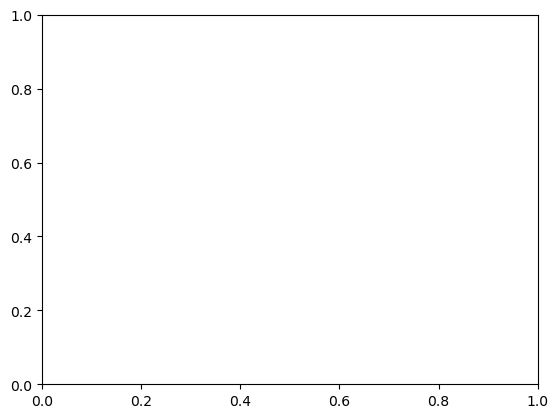

Iteration:14
ML: -1993.262; 	ML change (error):     1.479; 	Sigma^2:     0.388; 	Sigma^2 change:     0.013
[==========                                                              ]


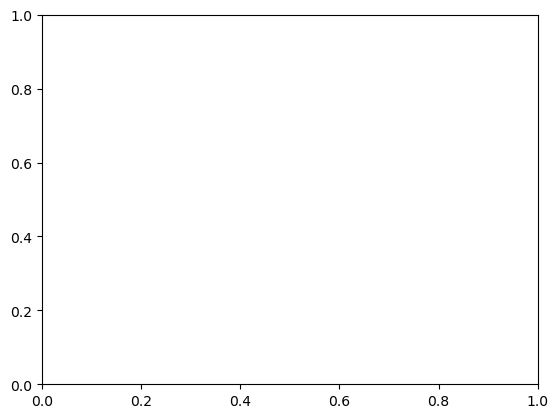

Iteration:15
ML: -1993.664; 	ML change (error):     0.403; 	Sigma^2:     0.381; 	Sigma^2 change:     0.007
[==========                                                              ]


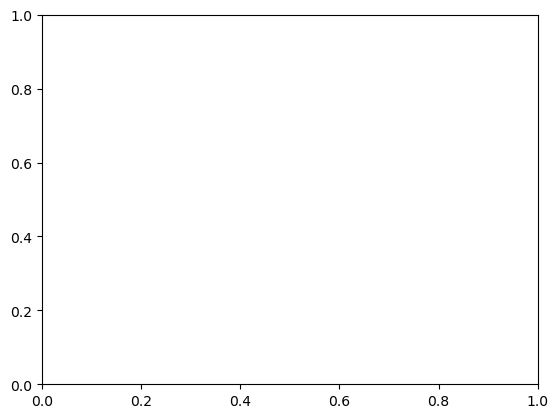

Iteration:16
ML: -1993.778; 	ML change (error):     0.113; 	Sigma^2:     0.378; 	Sigma^2 change:     0.004
[===========                                                             ]


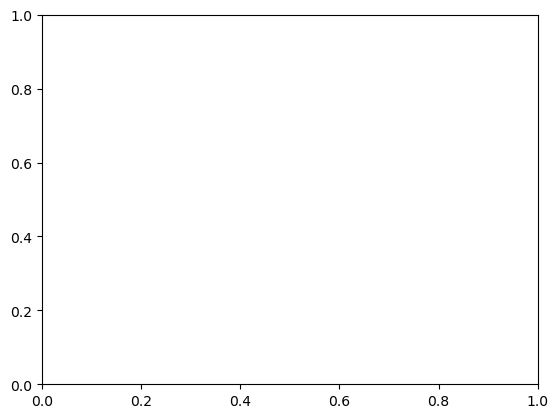

Iteration:17
ML: -1993.810; 	ML change (error):     0.033; 	Sigma^2:     0.376; 	Sigma^2 change:     0.002
[============                                                            ]


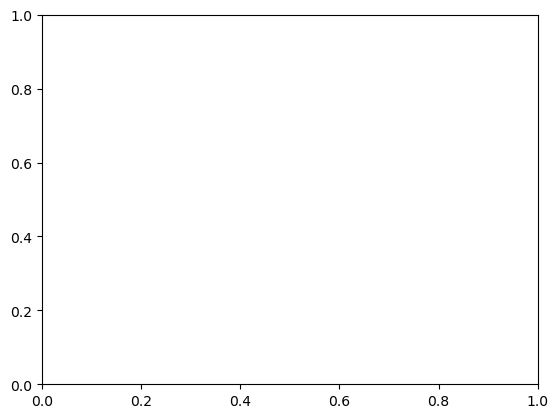

Iteration:18
ML: -1993.819; 	ML change (error):     0.009; 	Sigma^2:     0.375; 	Sigma^2 change:     0.001
[============                                                            ]


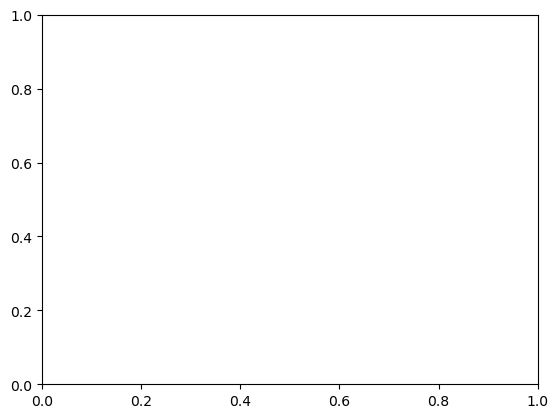

Iteration:19
ML: -1993.822; 	ML change (error):     0.003; 	Sigma^2:     0.375; 	Sigma^2 change:     0.001
[=============                                                           ]


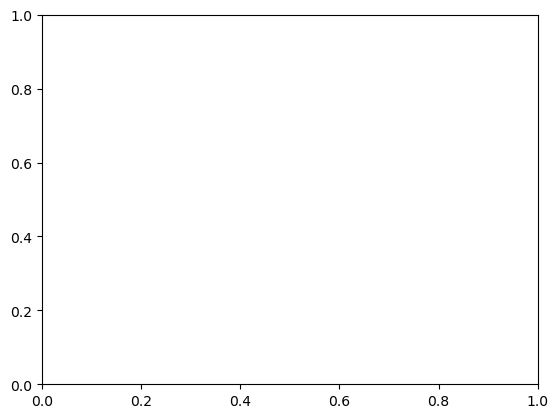

Iteration:20
ML: -1993.823; 	ML change (error):     0.001; 	Sigma^2:     0.374; 	Sigma^2 change:     0.000
[==============                                                          ]


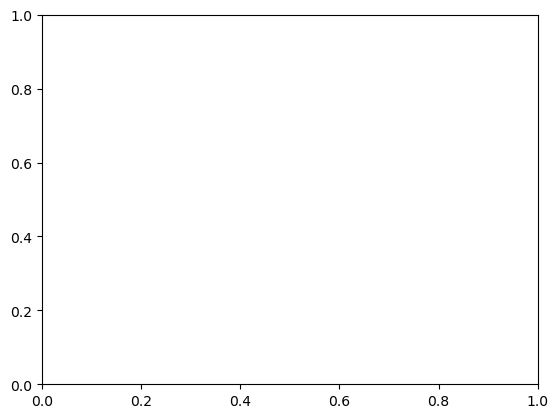

Iteration:21
ML: -1993.823; 	ML change (error):     0.000; 	Sigma^2:     0.374; 	Sigma^2 change:     0.000
[===============                                                         ]


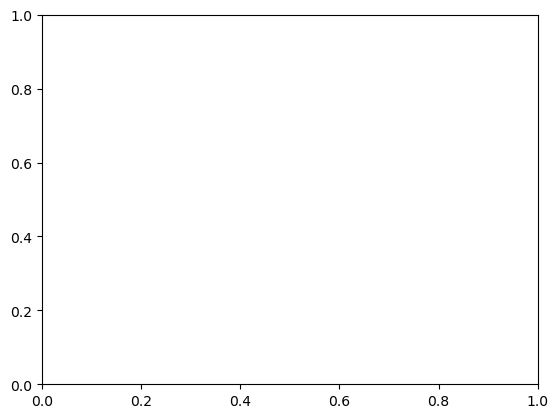

Iteration:22
ML: -1993.823; 	ML change (error):     0.000; 	Sigma^2:     0.374; 	Sigma^2 change:     0.000
[===============                                                         ]


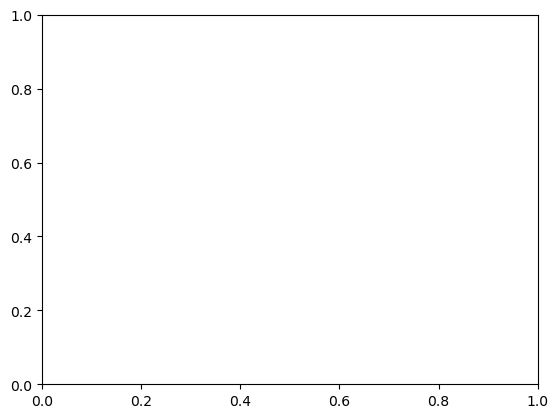

Iteration:23
ML: -1993.823; 	ML change (error):     0.000; 	Sigma^2:     0.374; 	Sigma^2 change:     0.000
[================                                                        ]


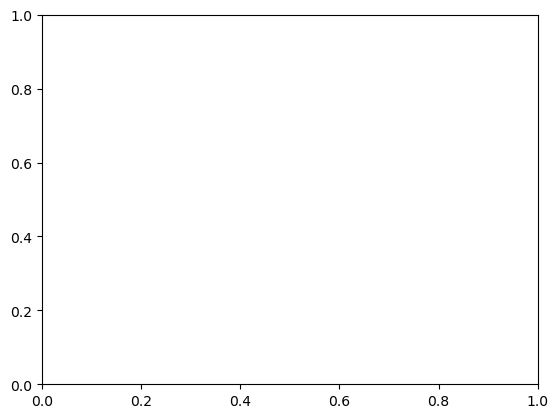

Iteration:24
ML: -1993.823; 	ML change (error):     0.000; 	Sigma^2:     0.374; 	Sigma^2 change:     0.000
[=================                                                       ]


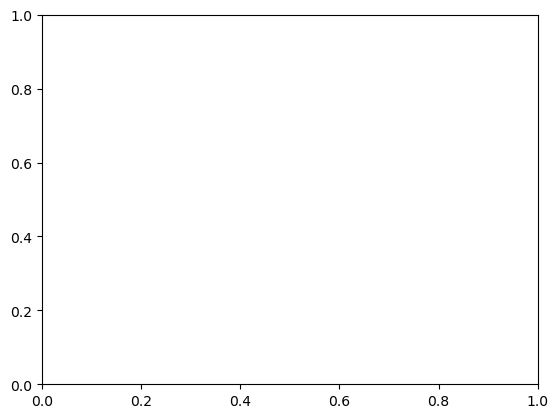

Registration Performance Metrics
Time to initialize EM: 0.00032210350036621094
Time to initialize registration: 1.4781951904296875e-05
Average Expectation Time:                    0.0017 +/- 0.0027
Average Maximization Time:                   0.0005 +/- 0.0012
Maximization Times - Per individual step
Average Update Transform Time:               0.0002 +/- 0.0001
Average Transform Time:                      0.0000 +/- 0.0000
Average Update Variance Time:                0.0002 +/- 0.0011

Number of iterations performed:          24
Error at time of finish:                 5.802872010463034e-06


In [ ]:
from functools import partial
from cycpd import rigid_registration
from PIL import Image

# theta = np.pi / 6.0
# R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
# t = np.array([0.5, 1.0, -2.0])

fig, ax = plt.subplots(1,1)

ax.cla()

ax.scatter(ref_set_points[:, 0], ref_set_points[:, 1], color="blue", label="Target", alpha=0.5, s=3)
ax.scatter(new_dat_set_points[:, 0], new_dat_set_points[:, 1], color="orange", label="Source", alpha=0.8, s=3)
ax.legend(loc="upper left", fontsize="x-large")
ax.text(
    0.87,
    0.92,
    "Iteration: 0",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize="x-large",
)
plt.draw()
fig.savefig("../plots/rigid/rigid_0000.tiff")  # Used for making gif.

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="rigid", save_fig=True)

reg = rigid_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
# plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/rigid/{f}" for f in os.listdir("../plots/rigid") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/rigid/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

## Affine and deformable

In [ ]:
# theta = np.pi / 6.0
# R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
# t = np.array([0.5, 1.0, -2.0])

fig, ax = plt.subplots(1,1)

ax.cla()

ax.scatter(ref_set_points[:, 0], ref_set_points[:, 1], color="blue", label="Target", alpha=0.5, s=3)
ax.scatter(new_dat_set_points[:, 0], new_dat_set_points[:, 1], color="orange", label="Source", alpha=0.8, s=3)
ax.legend(loc="upper left", fontsize="x-large")
ax.text(
    0.87,
    0.92,
    "Iteration: 0",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize="x-large",
)
plt.draw()
fig.savefig("../plots/affine/affine_0000.tiff")  # Used for making gif.

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="affine", save_fig=True)

reg = affine_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/affine/{f}" for f in os.listdir("../plots/affine") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/affine/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.cla()

ax.scatter(ref_set_points[:, 0], ref_set_points[:, 1], color="blue", label="Target", alpha=0.5, s=3)
ax.scatter(new_dat_set_points[:, 0], new_dat_set_points[:, 1], color="orange", label="Source", alpha=0.8, s=3)
ax.legend(loc="upper left", fontsize="x-large")
ax.text(
    0.87,
    0.92,
    "Iteration: 0",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize="x-large",
)
plt.draw()
fig.savefig("../plots/deformable/deformable_0000.tiff")  # Used for making gif.

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="deformable", save_fig=True)

reg = deformable_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/deformable/{f}" for f in os.listdir("../plots/deformable") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/deformable/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

Hmm, weird how deformable and affine didn't work well. Best don't bother with it for now.